In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sunset2/2.png
/kaggle/input/sunset2/1.jpeg
/kaggle/input/ghibli2/IMG_9837.jpg
/kaggle/input/ghibli2/ghibli_style.jpg
/kaggle/input/brutalism-and-more/vg_houses.jpg
/kaggle/input/brutalism-and-more/vg_self.jpg
/kaggle/input/brutalism-and-more/vg_wheat_field.jpg
/kaggle/input/brutalism-and-more/Brutalism2.jpg
/kaggle/input/brutalism-and-more/Brutalism3.jpg
/kaggle/input/brutalism-and-more/Brutalism.jpg
/kaggle/input/brutalism-and-more/jdskng9qjlce1.png
/kaggle/input/monalisa/1115343.jpg
/kaggle/input/video-1/V1.mp4
/kaggle/input/sample/style.jpg
/kaggle/input/sample/content.jpg
/kaggle/input/video-final/sea-landscape-with-digital-art-style (1).jpg
/kaggle/input/video-final/V1.mp4
/kaggle/input/sample-2/pexels-pixabay-417273.jpg
/kaggle/input/sample-2/style.jpg
/kaggle/input/miximages/sea-landscape-with-digital-art-style.jpg
/kaggle/input/miximages/DSC_0782_Original.JPG
/kaggle/input/miximages/sea-landscape-with-digital-art-style (1).jpg
/kaggle/input/miximages/europeana-Wfu

In [ ]:
# Cell 1: Setup
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install matplotlib pillow requests tqdm

Looking in indexes: https://download.pytorch.org/whl/cu118
INFO: pip is looking at multiple versions of torch to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.2/23.2 MB 32.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 875.6/875.6 kB 48.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 75.6 MB/s eta 0:00:0000:010:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 663.9/663.9 MB 2.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 417.9/417.9 MB 4.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 7.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 MB 18.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 MB 13.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.1/204.1 MB 1.7 MB/s eta 0:00:0000

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.utils import save_image
from PIL import Image
import matplotlib.pyplot as plt

print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())

PyTorch version: 2.6.0+cu124
CUDA available: True


In [7]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.utils import save_image
from PIL import Image
import matplotlib.pyplot as plt


class ImageStyleTransfer:
    def __init__(self, device=None):
        if device is None:
            device = "cuda" if torch.cuda.is_available() else "cpu"
        self.device = torch.device(device)
        print(f"Computing device: {self.device}")

        try:
            weights = models.VGG19_Weights.DEFAULT
            vgg = models.vgg19(weights=weights)
        except TypeError:
            vgg = models.vgg19(pretrained=True)

        self.vgg = vgg.features.to(self.device).eval()
        for p in self.vgg.parameters():
            p.requires_grad = False

        self.imagenet_mean = [0.485, 0.456, 0.406]
        self.imagenet_std = [0.229, 0.224, 0.225]

        self.mean = torch.tensor(self.imagenet_mean).view(1, 3, 1, 1).to(self.device)
        self.std = torch.tensor(self.imagenet_std).view(1, 3, 1, 1).to(self.device)

        self.content_idx = 21
        self.style_indices = [0, 5, 10, 19, 28]

    def _transform(self, target_height):
        return transforms.Compose([
            transforms.Resize(target_height),
            transforms.ToTensor(),
            transforms.Normalize(self.imagenet_mean, self.imagenet_std),
        ])

    def load_image(self, path, target_height=400):
        img = Image.open(path).convert("RGB")
        transform = self._transform(target_height)
        tensor = transform(img).unsqueeze(0).to(self.device)
        return tensor, img.size

    def denormalize(self, tensor):
        t = tensor.detach().clone()
        t = t * self.std + self.mean
        t = torch.clamp(t, 0, 1)
        return t.cpu()

    def get_feature_maps(self, x):
        features = []
        for i, layer in enumerate(self.vgg):
            x = layer(x)
            if i == self.content_idx or i in self.style_indices:
                features.append((i, x))
        return features

    def gram_matrix(self, x):
        b, c, h, w = x.size()
        F = x.view(b, c, h * w)
        G = torch.bmm(F, F.transpose(1, 2))
        return G / (h * w)

    def total_variation(self, img):
        diff_h = torch.abs(img[:, :, :, :-1] - img[:, :, :, 1:])
        diff_v = torch.abs(img[:, :, :-1, :] - img[:, :, 1:, :])
        return diff_h.mean() + diff_v.mean()

    def style_transfer(
        self,
        content_path,
        style_path,
        output_path="stylized_output.png",
        height=400,
        content_weight=1e5,
        style_weight=3e4,
        tv_weight=1.0,
        optimizer_type="lbfgs",
        init_method="content",
        num_steps_lbfgs=1000,
        num_steps_adam=400,
        lr_adam=10.0,
    ):
        content_img, _ = self.load_image(content_path, height)
        style_img, _ = self.load_image(style_path, height)

        if init_method == "random":
            init = torch.randn_like(content_img).to(self.device)
        elif init_method == "style":
            style_resized, _ = self.load_image(style_path, height)
            init = style_resized
        else:
            init = content_img.clone()

        optimizing_img = init.clone().requires_grad_(True)

        with torch.no_grad():
            content_feats = self.get_feature_maps(content_img)
            style_feats = self.get_feature_maps(style_img)

        target_content = None
        for idx, feat in content_feats:
            if idx == self.content_idx:
                target_content = feat.squeeze(0)
                break

        target_style_grams = []
        for idx, feat in style_feats:
            if idx in self.style_indices:
                G = self.gram_matrix(feat)
                target_style_grams.append(G)

        if optimizer_type == "adam":
            optimizer = optim.Adam([optimizing_img], lr=lr_adam)
            max_iter = num_steps_adam
        else:
            optimizer = optim.LBFGS([optimizing_img], max_iter=num_steps_lbfgs)
            max_iter = num_steps_lbfgs

        print(f"Optimization started with {optimizer_type.upper()} for {max_iter} iterations")
        print(f"Content weight: {content_weight}, Style weight: {style_weight}, TV weight: {tv_weight}")
        step_counter = 0

        def compute_losses(img):
            nonlocal step_counter
            step_counter += 1

            feats = self.get_feature_maps(img)

            current_content = None
            style_feats_current = []
            for idx, feat in feats:
                if idx == self.content_idx:
                    current_content = feat.squeeze(0)
                if idx in self.style_indices:
                    style_feats_current.append(feat)

            content_loss = nn.MSELoss(reduction="mean")(current_content, target_content)

            style_loss = 0.0
            current_grams = [self.gram_matrix(f) for f in style_feats_current]
            for G_t, G_c in zip(target_style_grams, current_grams):
                style_loss += nn.MSELoss(reduction="sum")(G_t, G_c)
            style_loss /= len(target_style_grams)

            tv_loss = self.total_variation(img)

            total = (
                content_weight * content_loss
                + style_weight * style_loss
                + tv_weight * tv_loss
            )

            if step_counter % 50 == 0 or step_counter <= 10:
                print(
                    f"Step {step_counter:04d} | "
                    f"Total Loss: {total.item():10.4f} | "
                    f"Content: {content_weight * content_loss.item():10.4f} | "
                    f"Style: {style_weight * style_loss.item():10.4f} | "
                    f"TV: {tv_weight * tv_loss.item():8.4f}"
                )

            return total, content_loss, style_loss, tv_loss

        if optimizer_type == "adam":
            for _ in range(max_iter):
                optimizer.zero_grad()
                total_loss, _, _, _ = compute_losses(optimizing_img)
                total_loss.backward()
                optimizer.step()
        else:
            def closure():
                optimizer.zero_grad()
                total_loss, _, _, _ = compute_losses(optimizing_img)
                total_loss.backward()
                return total_loss
            optimizer.step(closure)

        out_dir = os.path.dirname(output_path)
        if out_dir:
            os.makedirs(out_dir, exist_ok=True)

        final_img = self.denormalize(optimizing_img)
        save_image(final_img, output_path)
        print(f"Stylized image saved to: {output_path}")

        return optimizing_img

Using device: cuda
Start optimization with LBFGS for 1000 steps
content_weight=100000.0, style_weight=30000.0, tv_weight=1.0
step 0001 | Total=15792753664.0000 | C=    0.0000 | S=15792753750.0000 | TV=  0.0333
step 0002 | Total=15792320512.0000 | C=    0.0108 | S=15792320625.0000 | TV=  0.0333
step 0003 | Total=15368412160.0000 | C= 6937.5217 | S=15368404687.5000 | TV=  0.0340
step 0004 | Total=11002344448.0000 | C=228804.2784 | S=11002116562.5000 | TV=  0.0791
step 0005 | Total=11845442560.0000 | C=621668.4341 | S=11844821250.0000 | TV=  0.1342
step 0006 | Total=6760657408.0000 | C=497708.9882 | S=6760159687.5000 | TV=  0.1455
step 0007 | Total=6071501824.0000 | C=470125.2937 | S=6071032031.2500 | TV=  0.1499
step 0008 | Total=5037059584.0000 | C=455721.4260 | S=5036603906.2500 | TV=  0.1670
step 0009 | Total=3817914624.0000 | C=497030.2105 | S=3817417500.0000 | TV=  0.2010
step 0010 | Total=2795044864.0000 | C=553467.2260 | S=2794491328.1250 | TV=  0.2375
step 0050 | Total=151872976.

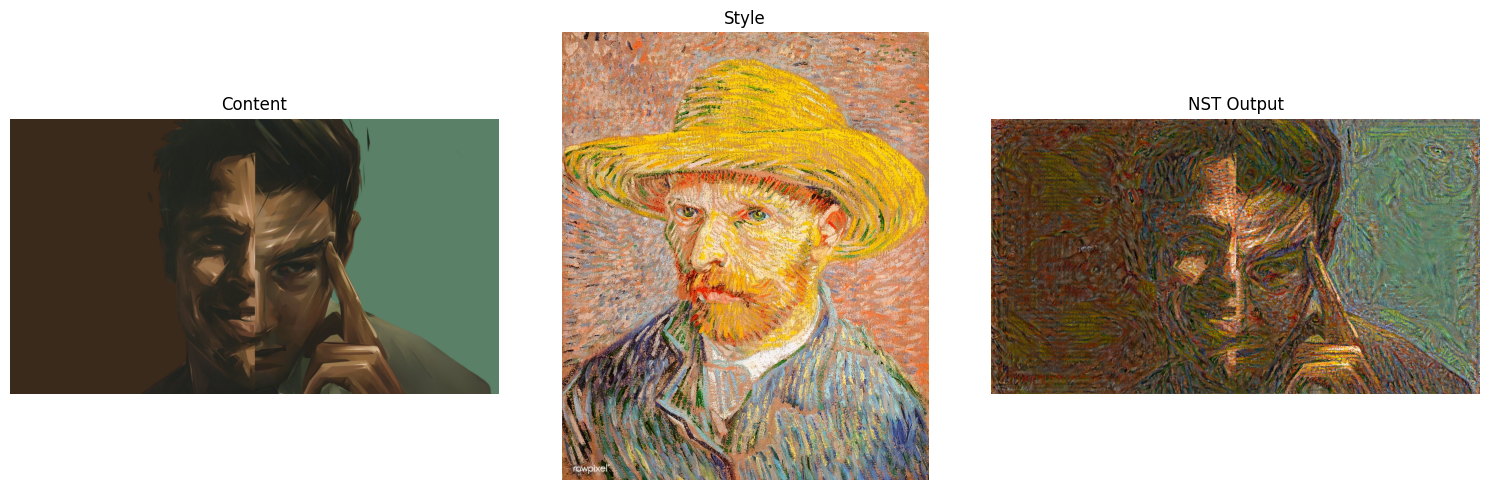

In [6]:
CONTENT_PATH = "/kaggle/input/brutalism-and-more/jdskng9qjlce1.png"
STYLE_PATH   = "/kaggle/input/brutalism-and-more/vg_self.jpg"
OUTPUT_PATH  = "/kaggle/working/fightclub_vgself2.png"

nst = ImageStyleTransfer()

_ = nst.style_transfer(
content_path=CONTENT_PATH,
style_path=STYLE_PATH,
output_path=OUTPUT_PATH,
height=512,              
content_weight=1e5,      
style_weight=3e4,
tv_weight=1.0,
optimizer_type="lbfgs", 
init_method="content",  
num_steps_lbfgs=1000,
)

content_img = Image.open(CONTENT_PATH).convert("RGB")
style_img   = Image.open(STYLE_PATH).convert("RGB")
output_img  = Image.open(OUTPUT_PATH).convert("RGB")
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(content_img); axes[0].set_title("Content"); axes[0].axis("off")
axes[1].imshow(style_img);   axes[1].set_title("Style");   axes[1].axis("off")
axes[2].imshow(output_img);  axes[2].set_title("NST Output"); axes[2].axis("off")
plt.tight_layout()
plt.show()

In [ ]:
CONTENT_PATH = "/kaggle/input/brutalism-and-more/Brutalism.jpg"
STYLE_PATH   = "/kaggle/input/sunset2/2.png"
OUTPUT_PATH  = "/kaggle/working/brutalism_sunset.png"

nst = ImageStyleTransfer()

_ = nst.style_transfer(
content_path=CONTENT_PATH,
style_path=STYLE_PATH,
output_path=OUTPUT_PATH,
height=512,              
content_weight=1e5,      
style_weight=3e4,
tv_weight=1.0,
optimizer_type="lbfgs", 
init_method="content",  
num_steps_lbfgs=1000,
)

content_img = Image.open(CONTENT_PATH).convert("RGB")
style_img   = Image.open(STYLE_PATH).convert("RGB")
output_img  = Image.open(OUTPUT_PATH).convert("RGB")
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(content_img); axes[0].set_title("Content"); axes[0].axis("off")
axes[1].imshow(style_img);   axes[1].set_title("Style");   axes[1].axis("off")
axes[2].imshow(output_img);  axes[2].set_title("NST Output"); axes[2].axis("off")
plt.tight_layout()
plt.show()

Computing device: cuda
Optimization started with LBFGS for 1000 iterations
Content weight: 100000.0, Style weight: 30000.0, TV weight: 1.0
Step 0001 | Total Loss: 13364093952.0000 | Content:     0.0000 | Style: 13364094375.0000 | TV:   0.1535
Step 0002 | Total Loss: 13360622592.0000 | Content:     0.0090 | Style: 13360622812.5000 | TV:   0.1535
Step 0003 | Total Loss: 4140517120.0000 | Content: 171861.4817 | Style: 4140345468.7500 | TV:   0.1595
Step 0004 | Total Loss: 2934641664.0000 | Content: 216649.7707 | Style: 2934425156.2500 | TV:   0.1603
Step 0005 | Total Loss: 1968795392.0000 | Content: 296859.1452 | Style: 1968498515.6250 | TV:   0.1620
Step 0006 | Total Loss: 1363368960.0000 | Content: 386079.5021 | Style: 1362982851.5625 | TV:   0.1649
Step 0007 | Total Loss: 1012401344.0000 | Content: 457632.7801 | Style: 1011943710.9375 | TV:   0.1685
Step 0008 | Total Loss: 831173120.0000 | Content: 535957.6702 | Style: 830637187.5000 | TV:   0.1734
Step 0009 | Total Loss: 769295104.000

Using device: cuda


Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:02<00:00, 227MB/s]  


Start optimization with LBFGS for 1500 steps
content_weight=100000.0, style_weight=30000.0, tv_weight=1.0
step 0001 | Total=7239134720.0000 | C=    0.0000 | S=7239134531.2500 | TV=  0.0593
step 0002 | Total=7238827520.0000 | C=    0.0057 | S=7238827500.0000 | TV=  0.0593
step 0003 | Total=6861452288.0000 | C= 6299.4793 | S=6861446250.0000 | TV=  0.0600
step 0004 | Total=6513873920.0000 | C=18863.3934 | S=6513855000.0000 | TV=  0.0607
step 0005 | Total=5552128512.0000 | C=134481.7281 | S=5551994062.5000 | TV=  0.0724
step 0006 | Total=4507747328.0000 | C=201560.5450 | S=4507545468.7500 | TV=  0.0792
step 0007 | Total=3718958080.0000 | C=235228.2524 | S=3718722890.6250 | TV=  0.0844
step 0008 | Total=3094738432.0000 | C=269234.1805 | S=3094469062.5000 | TV=  0.0895
step 0009 | Total=2587286272.0000 | C=282477.6888 | S=2587003828.1250 | TV=  0.0957
step 0010 | Total=2157571584.0000 | C=321542.9544 | S=2157250078.1250 | TV=  0.1042
step 0050 | Total=119158592.0000 | C=399279.4275 | S=11875

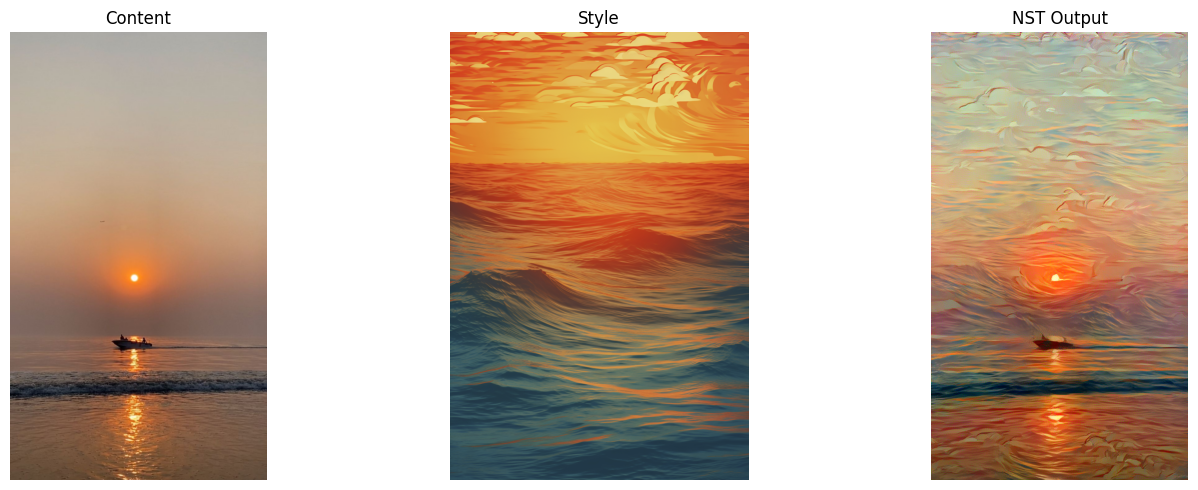

In [3]:
CONTENT_PATH = "/kaggle/input/sunset2/1.jpeg"
STYLE_PATH   = "/kaggle/input/miximages/sea-landscape-with-digital-art-style (1).jpg"
OUTPUT_PATH  = "/kaggle/working/sunset_mix.png"

nst = ImageStyleTransfer()

_ = nst.style_transfer(
content_path=CONTENT_PATH,
style_path=STYLE_PATH,
output_path=OUTPUT_PATH,
height=512,              
content_weight=1e5,     
style_weight=3e4,
tv_weight=1.0,
optimizer_type="lbfgs",
init_method="content",
num_steps_lbfgs=1500,
)


content_img = Image.open(CONTENT_PATH).convert("RGB")
style_img   = Image.open(STYLE_PATH).convert("RGB")
output_img  = Image.open(OUTPUT_PATH).convert("RGB")
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(content_img); axes[0].set_title("Content"); axes[0].axis("off")
axes[1].imshow(style_img);   axes[1].set_title("Style");   axes[1].axis("off")
axes[2].imshow(output_img);  axes[2].set_title("NST Output"); axes[2].axis("off")
plt.tight_layout()
plt.show()